In [2]:
import pandas as pd

dataset = "data/IMDB Dataset.csv"
df = pd.read_csv(dataset, sep=",")

In [4]:
df = df[:1000]

In [5]:
from sklearn.model_selection import train_test_split
X,y = df['review'].values,df['sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

print(f'Training Data shape : {X_train.shape}')
print(f'Test Data shape     : {X_test.shape}')

print(f'Training Target shape : {y_train.shape}')
print(f'Test Target shape     : {y_test.shape}')

Training Data shape : (750,)
Test Data shape     : (250,)
Training Target shape : (750,)
Test Target shape     : (250,)


In [ ]:
X_train[0]

In [ ]:
y_train[0]

## Feature Creation

In [6]:
from nltk.corpus import stopwords
import string
import re
from collections import Counter
import numpy as np

In [7]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def mytokenizer(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:2000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [ ]:
# x_train,y_train,x_test,y_test,vocab = mytokenizer(x_train,y_train,x_test,y_test)

There's a possibility that you might get an error message that looks like this:

    LookupError: 
    **********************************************************************
      Resource stopwords not found.
      Please use the NLTK Downloader to obtain the resource:

      >>> import nltk
      >>> nltk.download('stopwords')

      For more information see: https://www.nltk.org/data.html

      Attempted to load corpora/stopwords

      Searched in:
        - 'C:\\Users\\Joshi008/nltk_data'
        - 'C:\\Users\\Joshi008\\Anaconda3\\nltk_data'
        - 'C:\\Users\\Joshi008\\Anaconda3\\share\\nltk_data'
        - 'C:\\Users\\Joshi008\\Anaconda3\\lib\\nltk_data'
        - 'C:\\Users\\Joshi008\\AppData\\Roaming\\nltk_data'
        - 'C:\\nltk_data'
        - 'D:\\nltk_data'
        - 'E:\\nltk_data'
    **********************************************************************
    
This means we do not have a list of stopwords in nltk, which we can install using nltk.download(). This is required only once in your python environment.

In [ ]:
# import nltk
# nltk.download()

In [8]:
X_train,y_train,X_test,y_test,vocab = mytokenizer(X_train,y_train,X_test,y_test)

<ipython-input-7-2e4b3d00f3f4>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [9]:
X_train[0]

[2,
 206,
 834,
 494,
 477,
 10,
 169,
 53,
 138,
 104,
 279,
 5,
 53,
 354,
 343,
 6,
 707,
 117,
 2,
 1384,
 22,
 1550,
 59,
 3,
 68,
 786,
 645,
 272,
 11,
 7,
 92,
 1725,
 101,
 76,
 7,
 144,
 48,
 12]

In [10]:
type(X_trainvectors)

NameError: name 'X_trainvectors' is not defined

In [ ]:
type(vocab)

As we are planning to use RNN for this task, RNN use sequences to be of a certain length - thus, if a sentence is too short, we will have to pad the sequence, potentially with 0s. If a sentence is too long, we have to decide a maximum length and truncate - which might happen more often during the prediction phase when we encounter previously unseen data. To decide that length, let's explore the training dataset and see how long the reviews are.

In [11]:
review_length = [len(i) for i in X_train]
print ("Average Review Length : {} \nMaximum Review Length : {} ".format(pd.Series(review_length).mean(), pd.Series(review_length).max()))


Average Review Length : 84.58266666666667 
Maximum Review Length : 405 


In [12]:
def pad(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features



In [ ]:
test = pad(np.array([list(range(30))]), 20)
test

In [13]:
X_train = pad(X_train,200)
X_test = pad(X_test,200)

In [ ]:
X_train.shape

## Preparing for Pytorch

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size=50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# # obtain one batch of training data
# dataiter = iter(train_loader)
# sample_x, sample_y = dataiter.next()

# print('Sample input size: ', sample_x.size()) # batch_size, seq_length
# print('Sample input: \n', sample_x)
# print('Sample input: \n', sample_y)

In [16]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print (device)


cpu


In [17]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentAnalysisModel,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
    
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [18]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentAnalysisModel(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentAnalysisModel(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [21]:
# function to predict accuracy
def acc(pred,label):
    return torch.sum(torch.round(pred.squeeze()) == label.squeeze()).item()

In [22]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

clip = 5
epochs = 10 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'data/temp/state_dict.pt')
        print('Validation loss change ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print('\n')
    

Epoch 1
train_loss : 0.6903249303499858 val_loss : 0.6897501349449158
train_accuracy : 54.666666666666664 val_accuracy : 52.400000000000006
Validation loss change (inf --> 0.689750).  Saving model ...


Epoch 2
train_loss : 0.6426109115282694 val_loss : 0.7218503952026367
train_accuracy : 64.8 val_accuracy : 57.199999999999996


Epoch 3
train_loss : 0.5857517679532369 val_loss : 0.6882172226905823
train_accuracy : 71.46666666666667 val_accuracy : 61.6
Validation loss change (0.689750 --> 0.688217).  Saving model ...


Epoch 4
train_loss : 0.510674113035202 val_loss : 0.7210265636444092
train_accuracy : 73.46666666666667 val_accuracy : 56.00000000000001


Epoch 5
train_loss : 0.44130733410517375 val_loss : 0.8054465770721435
train_accuracy : 80.13333333333334 val_accuracy : 60.4


Epoch 6
train_loss : 0.35842082897822064 val_loss : 0.8980333805084229
train_accuracy : 84.39999999999999 val_accuracy : 60.0


Epoch 7
train_loss : 0.24444662928581237 val_loss : 0.936332619190216
train_accur

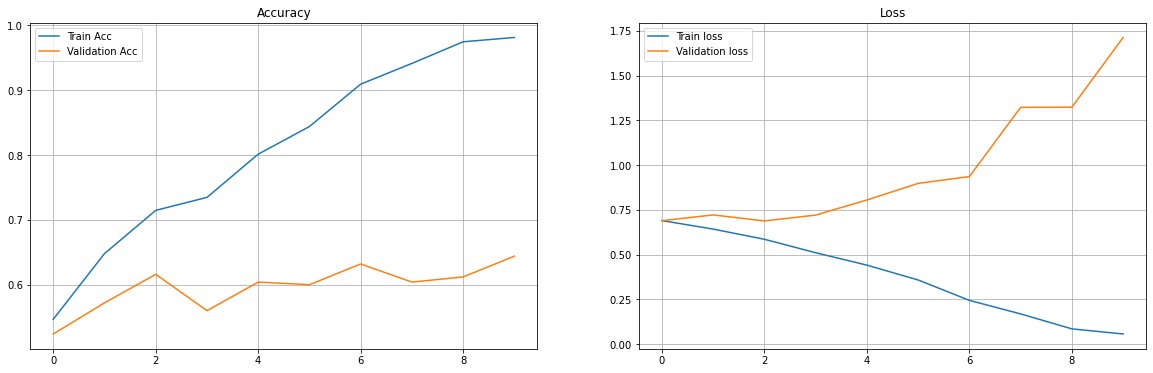

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [29]:
def inference(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    padded =  torch.from_numpy(pad(word_seq,200))
    inputs = padded.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return(output.item())
    
inference("Yuck it was so bad and horrible")

0.003339653369039297

In [32]:
from flask import Flask
app = Flask(__name__)

@app.route('/hello')
def hello():
    return 'Hello World!'

app.run(port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Nov/2021 14:25:34] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [28/Nov/2021 14:25:34] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [28/Nov/2021 14:26:03] "GET /hello HTTP/1.1" 200 -
